In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import  datasets

In [2]:
class RANSAC1: 
 
    def __init__(self, max_iters_k=100, treshold=0.5, min_acceptable_inliers = 100):
 
        self.max_iters_k = max_iters_k
        self.treshold = treshold
        self.min_acceptable_inliers = min_acceptable_inliers
 
        self.best_model = None
        self.best_inlier_count = 0
        self.inlier_mask = None
        
 
    def fit(self, X,y, show_partial_results = False):
 
        assert X.shape[1] == 1, 'The imput matrix should have only one dimension/column'
        assert X.shape[0] > 1.5 * self.min_acceptable_inliers, "The inmut matrix should have more data"
 
        # initialize data
        self.best_model = None
        self.best_inlier_count = 0
        self.inlier_mask = None
 
        #prepare data
        sample_size = X.shape[1] + 1
        data = np.hstack( (X[:,0].reshape(-1,1), y.reshape(-1,1)) )
 
        for i in range(self.max_iters_k):
 
            # randomly choose points
            rand_idx = np.random.choice(len(data), size=sample_size, replace=False)
            points = data[rand_idx,:]           
 
            # determine the line equation
            a = (points[0,1] - points[1,1]) / (points[0,0] - points[1,0] + 
                sys.float_info.epsilon) 
 
            b = points[0,1]- a * points[0,0]         
 
            # calculate "predicted" points            
            y_pred = a * data[:,0] + b            
 
            # determine points within threshold
            this_inlier_mask = np.square(y_pred - y) < self.treshold
            this_inlier_count = np.sum(this_inlier_mask)            
 
            # check if a better model was found. If yes - save it
            better_found = ((this_inlier_count > self.min_acceptable_inliers)
                            and (this_inlier_count > self.best_inlier_count))          
 
            if better_found:
 
                self.best_model = (a,b)
                self.best_inlier_count = this_inlier_count
                self.inlier_mask = this_inlier_mask
 
            if show_partial_results:
                
                line_X = np.arange(X.min(), X.max())[:, np.newaxis]
                line_y = a * line_X + b
 
                plt.scatter(X[this_inlier_mask], y[this_inlier_mask], color='green', 
                            marker='.', label='Inliers')
                plt.scatter(X[~this_inlier_mask], y[~this_inlier_mask], color='red', 
                            marker='.', label='Outliers')
                plt.plot(line_X, line_y, color='blue', linewidth=2, label='RANSAC')
                plt.scatter(points[:,0], points[:,1], color='black', 
                            marker='o', label='Sampled points', s=100)
                plt.legend(loc='lower right')
                plt.xlabel("Input")
                plt.ylabel("Response")
                plt.show()

In [3]:
cols = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS',
        'RAD','TAX','PTRATIO','B','LSTAT','MEDV']
 
data = pd.read_csv(r"..\data\housing.data",
                   sep=' +', engine='python', header=None, 
                   names=cols)

In [4]:
X = data.loc[:, 'LSTAT'].values.reshape(-1,1)
y = data['MEDV'].values

In [6]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

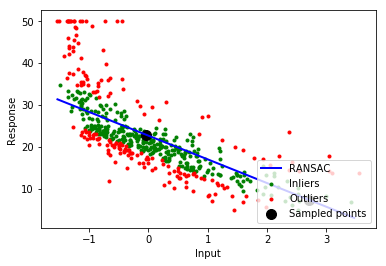

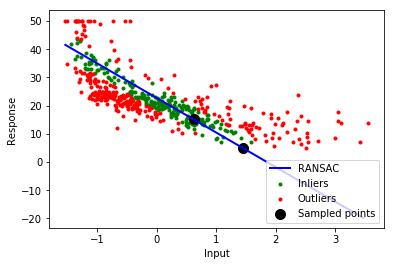

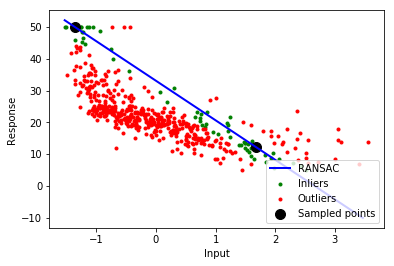

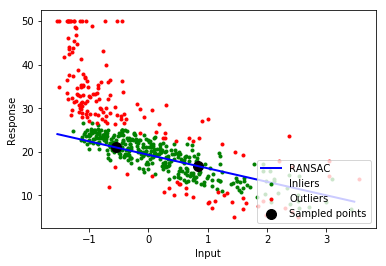

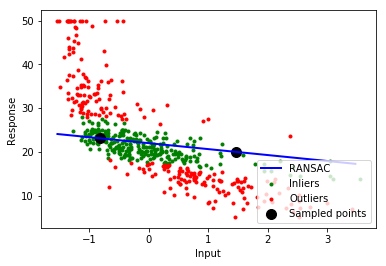

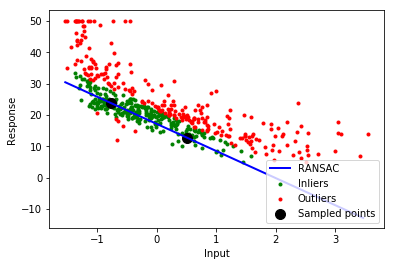

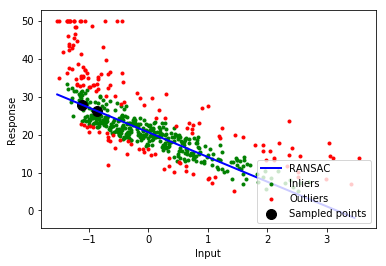

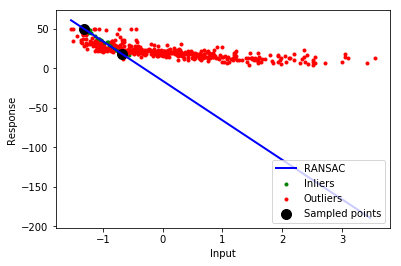

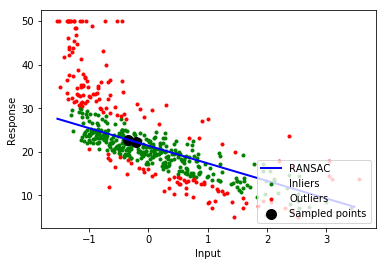

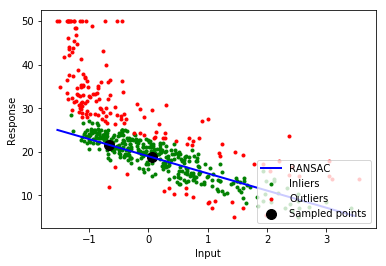

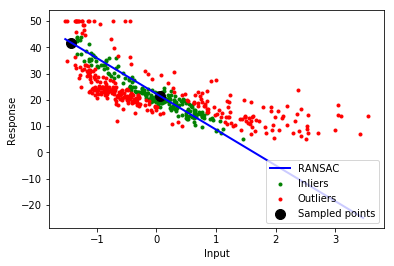

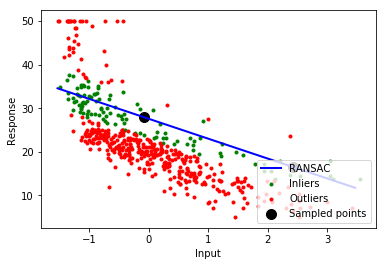

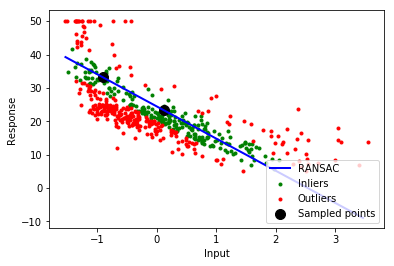

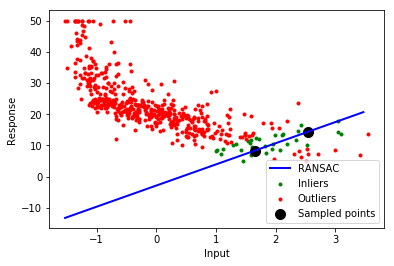

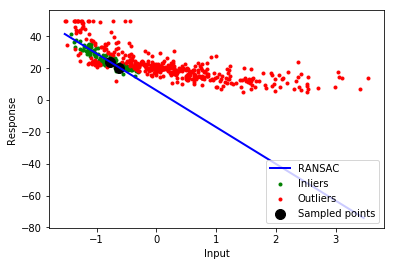

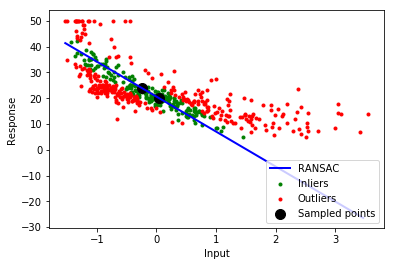

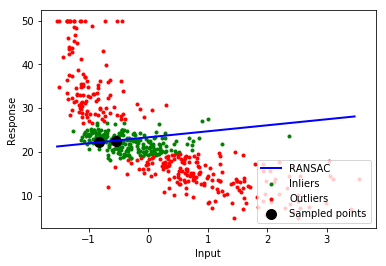

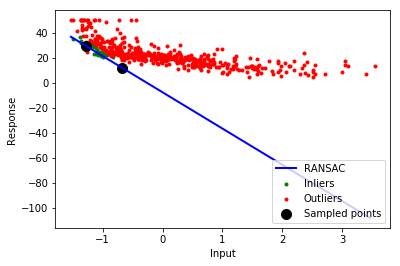

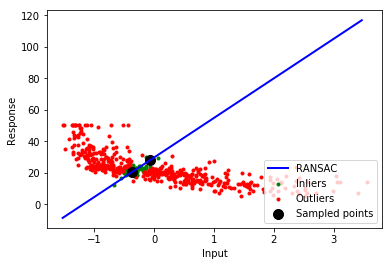

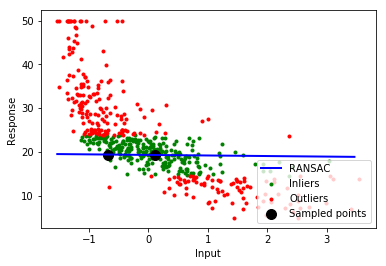

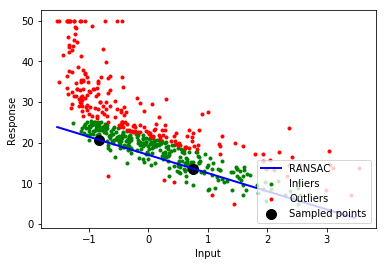

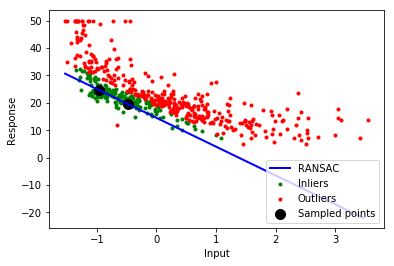

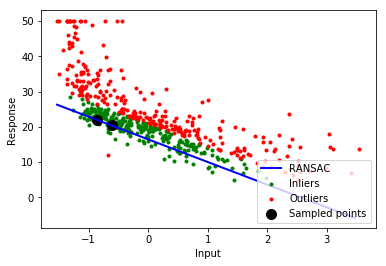

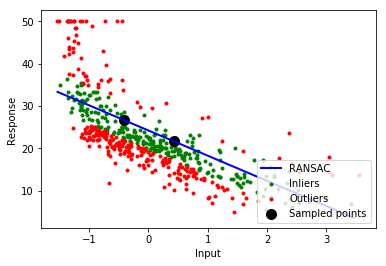

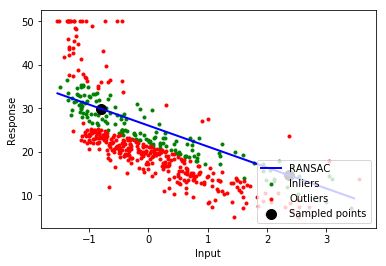

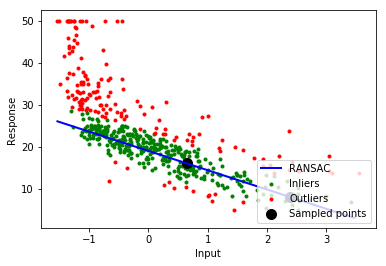

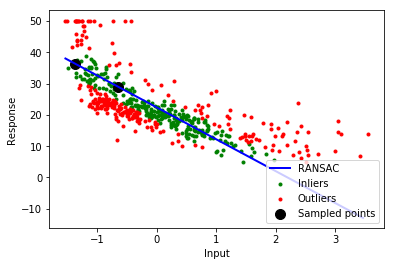

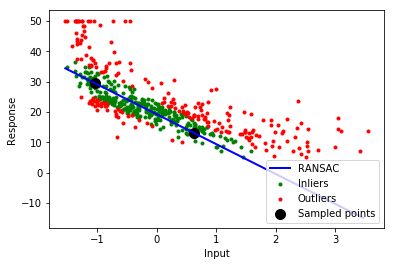

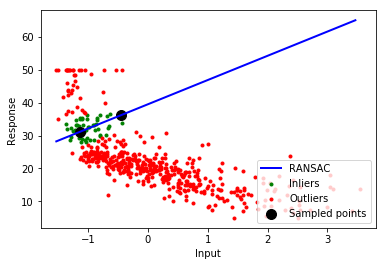

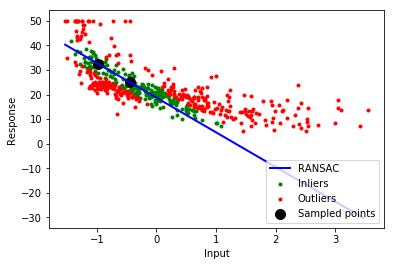

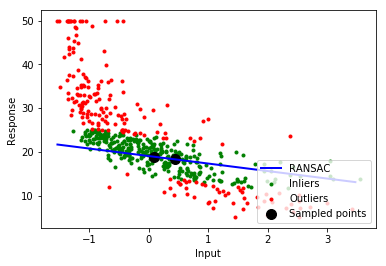

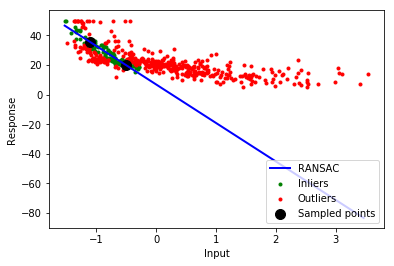

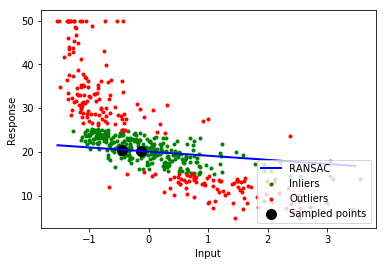

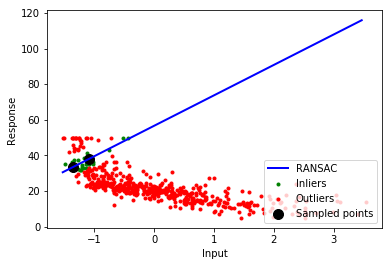

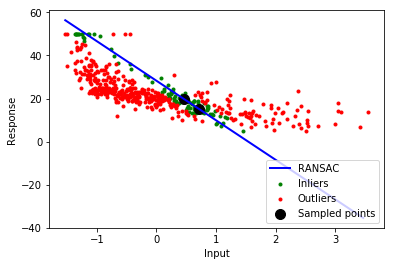

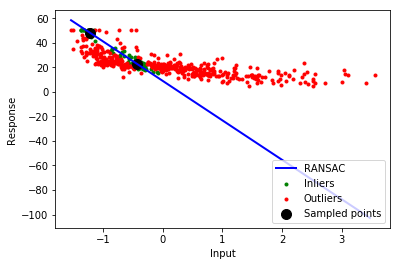

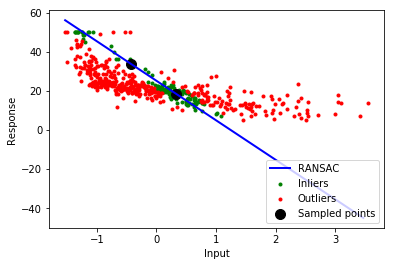

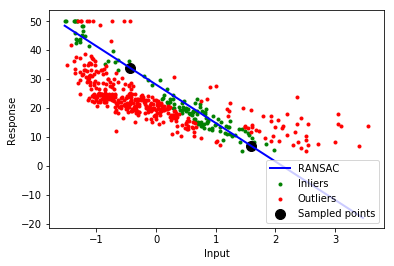

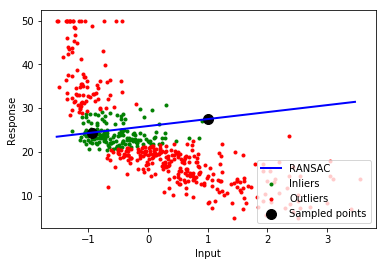

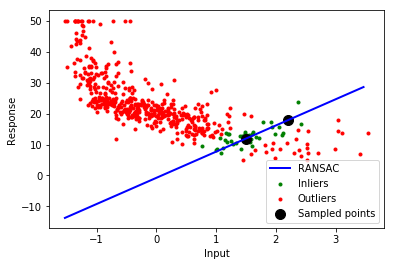

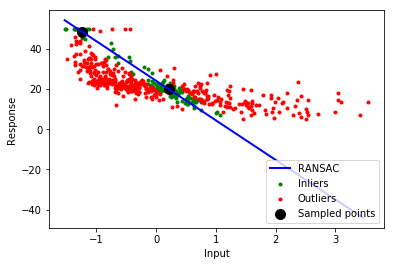

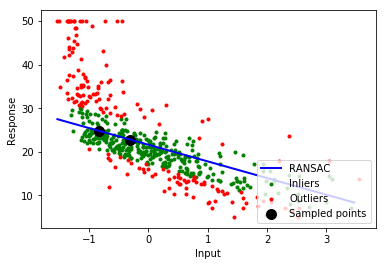

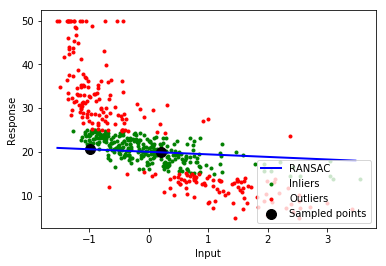

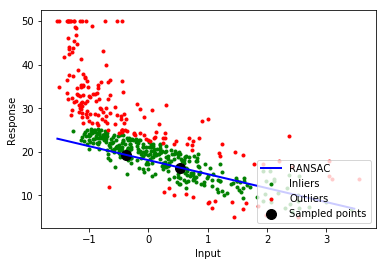

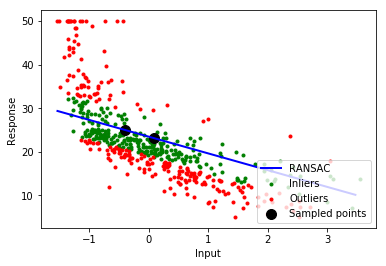

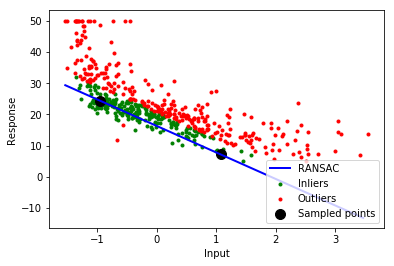

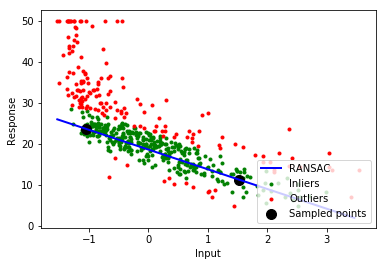

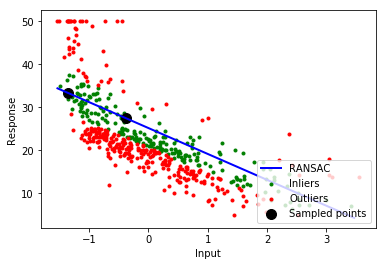

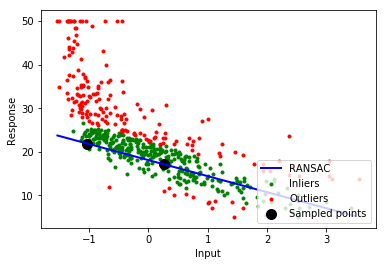

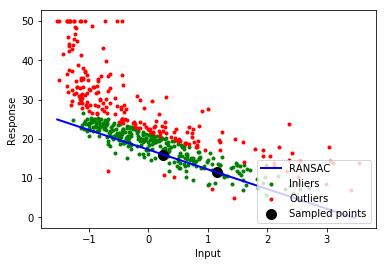

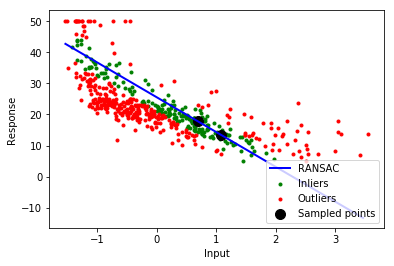

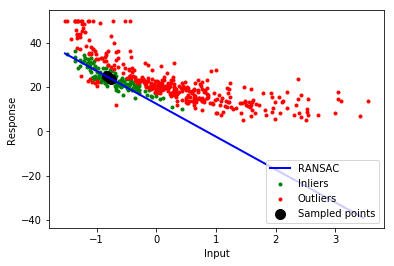

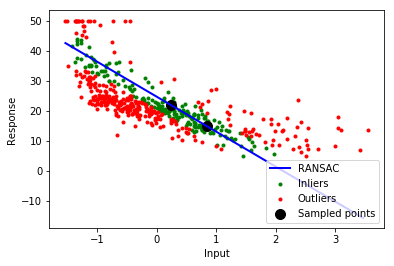

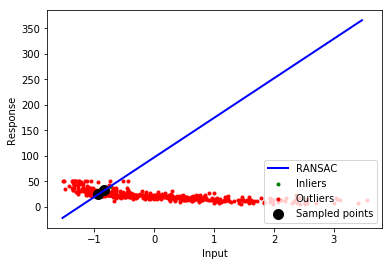

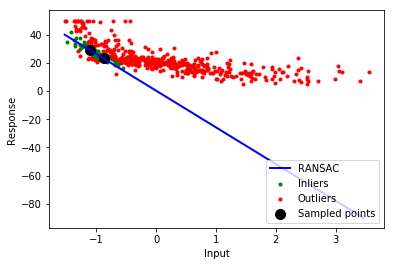

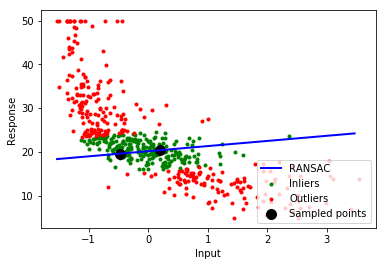

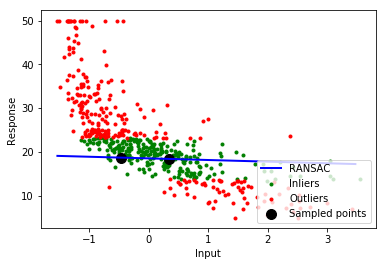

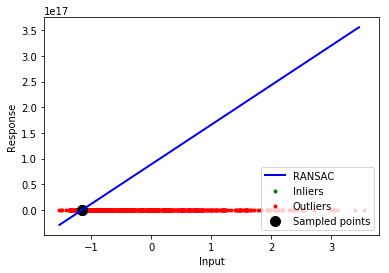

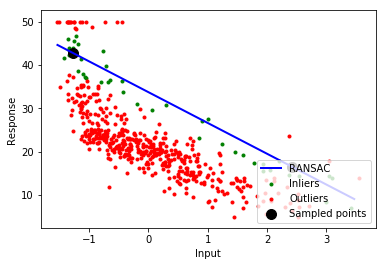

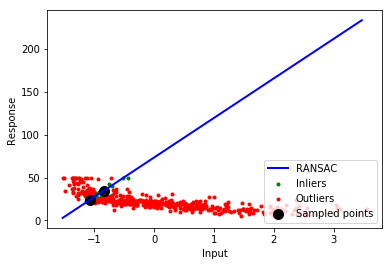

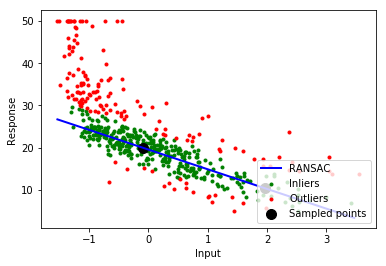

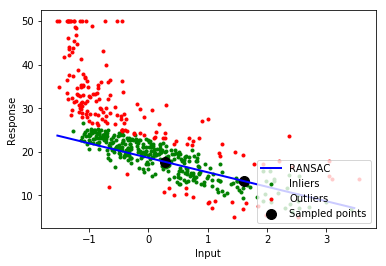

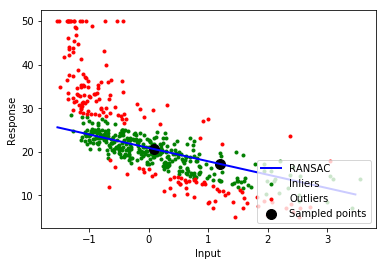

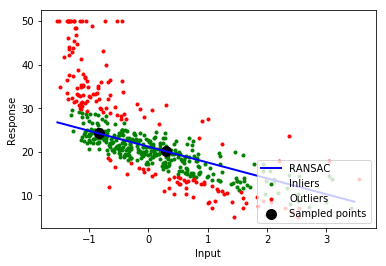

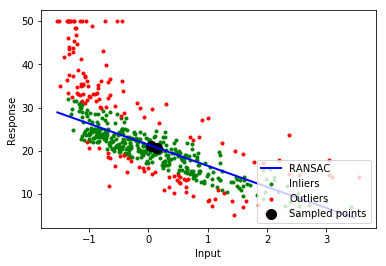

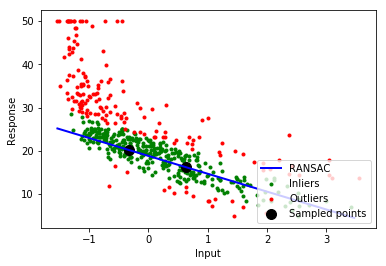

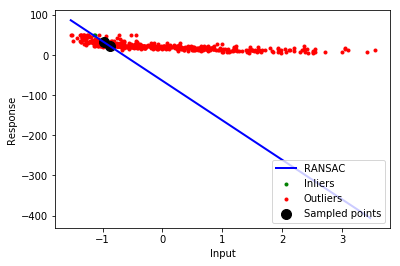

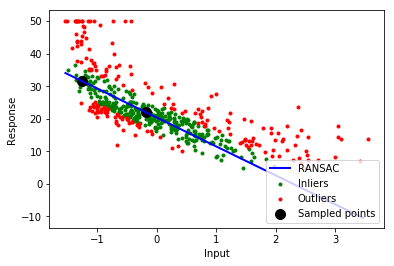

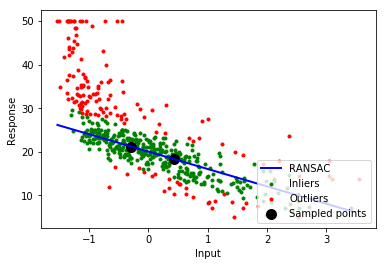

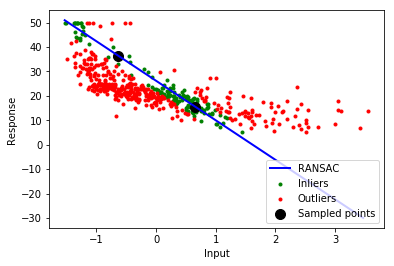

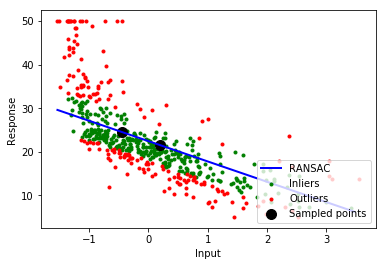

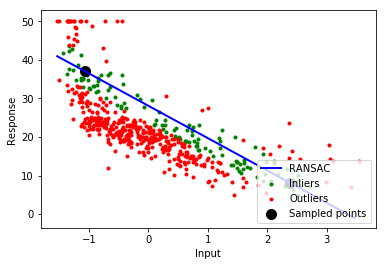

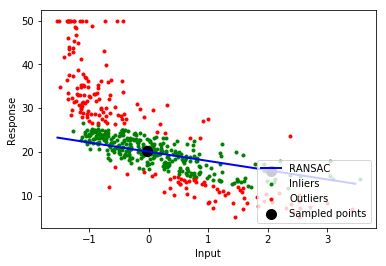

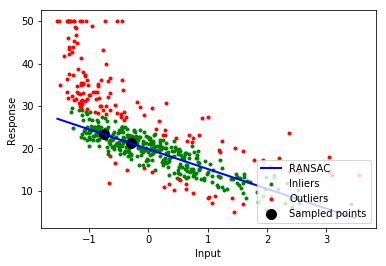

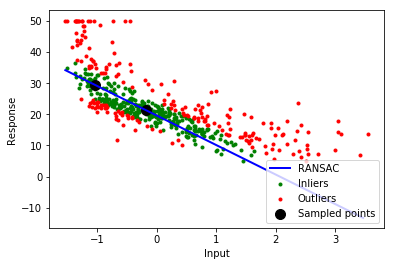

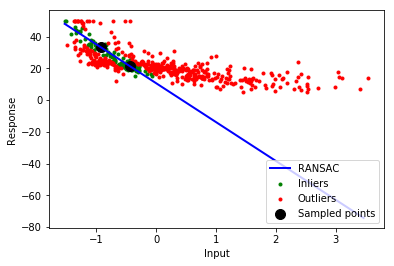

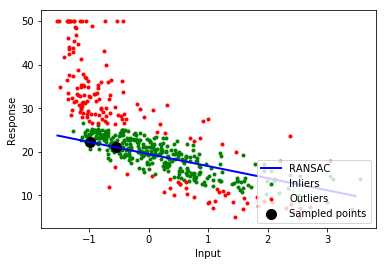

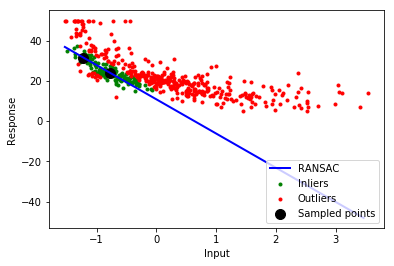

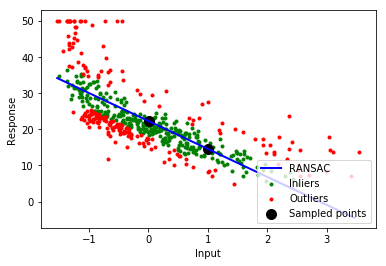

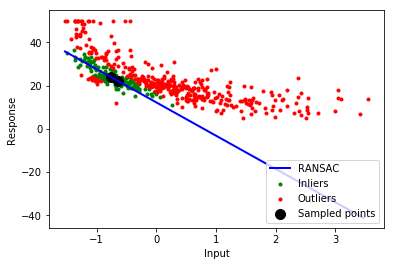

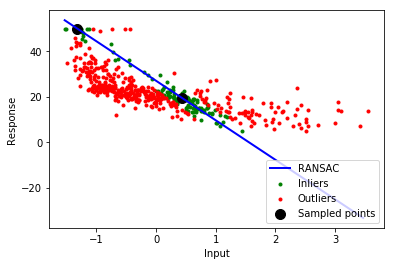

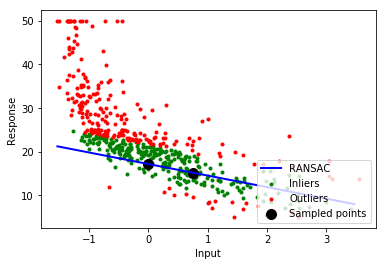

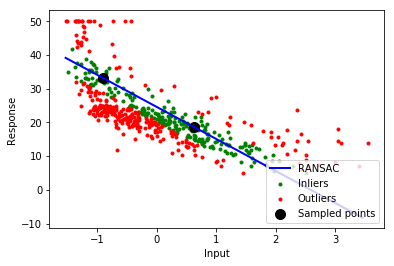

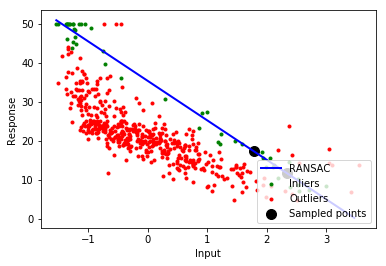

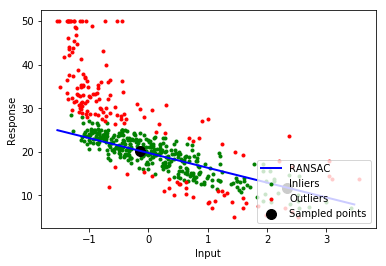

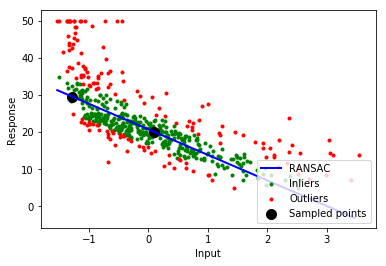

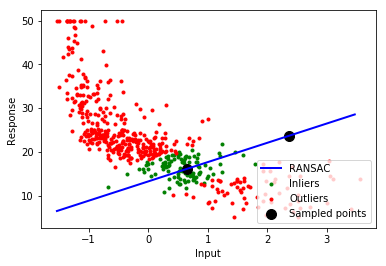

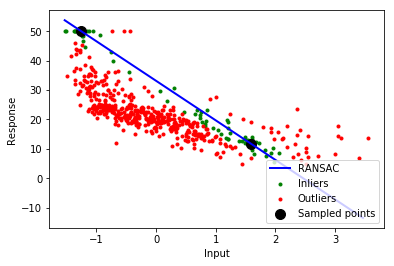

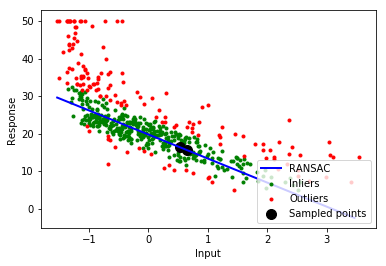

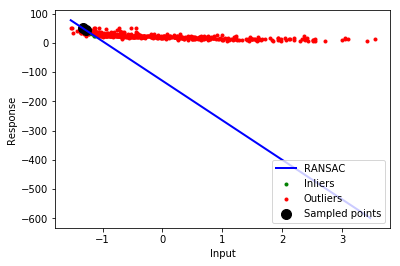

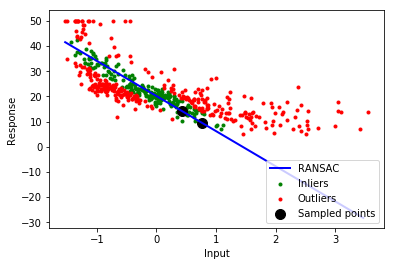

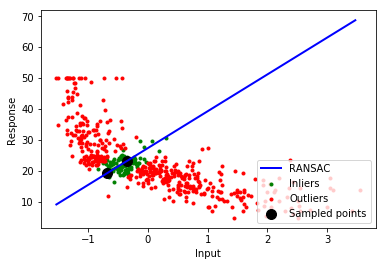

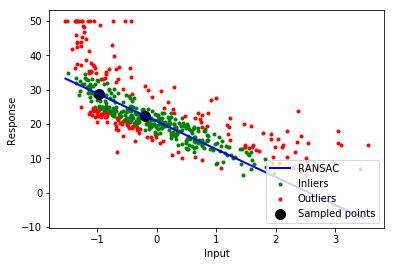

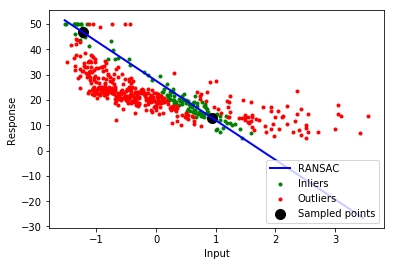

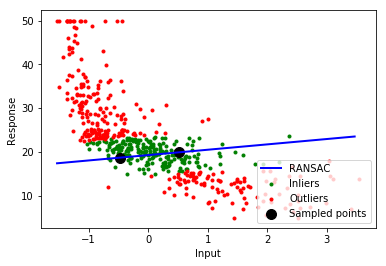

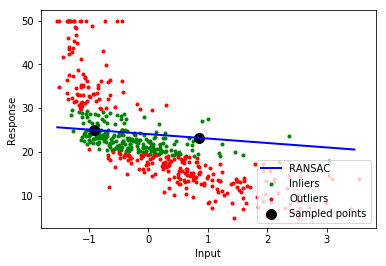

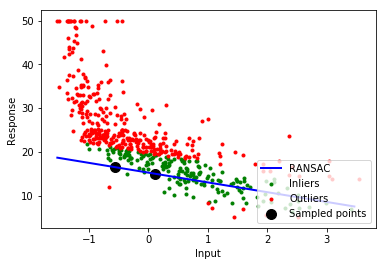

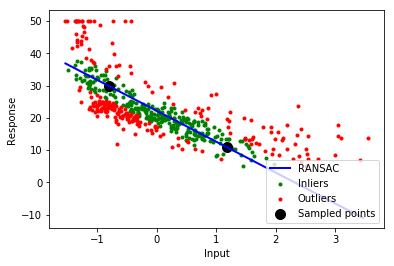

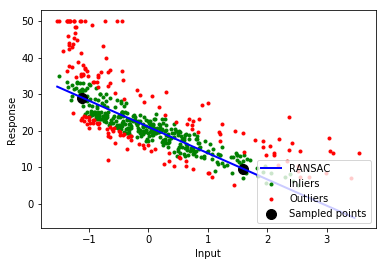

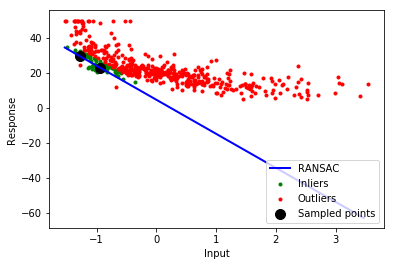

In [7]:
ransac = RANSAC1(max_iters_k = 100, treshold = 20, min_acceptable_inliers = 100)
ransac.fit(X, y, show_partial_results=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X[ransac.inlier_mask], y[ransac.inlier_mask], test_size=0.3)
lr = LinearRegression()
lr.fit(X_train, y_train)                
y_pred = lr.predict(X_test)  

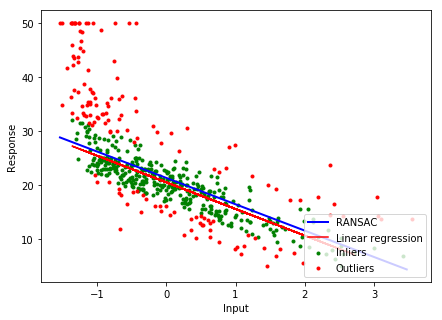

In [9]:
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = ransac.best_model[0] * line_X + ransac.best_model[1]
 
plt.figure(figsize=(7,5))
plt.scatter(X[ransac.inlier_mask], y[ransac.inlier_mask], color='green', 
            marker='.', label='Inliers')
plt.scatter(X[~ransac.inlier_mask], y[~ransac.inlier_mask], color='red', 
            marker='.', label='Outliers')
plt.plot(line_X, line_y, color='blue', linewidth=2, label='RANSAC')
plt.plot(X_test, y_pred, color='red', label='Linear regression')
 
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()   